## Antenna Matrix Notebook
Katherine Elder

When we made movies of the raw cross-polarized data for the entire IDR2.1 run, we noticed objects that didn't change with time. This would suggest that the data responsible for those objects was not coming from the sky, but from the other antennas. To investigate this further, we decided to look at the delay transforms. As we looked at the various plots, patterns started appearing. For instance, for many antenna pairs, the highest peak in the graph would appear at a delay time roughly corresponding to the baseline length between the antennas. 

### Part 1: Matrix Plots

To get a better look at this and possibly pick up on more patterns, we decided to plot matricies of the antenna pairs. The color of the squares relate to either the amplitude of the maximum peak of the delay transform for the given antenna pair, or the corresponding delay time of the peak. 

To do this, we read in a file holding the entire run of data (created by read_all_uvfits.py) and then run through every unique antenna pair. Without plotting, we find the maximum amplitude (y-value) and it's corresponding delay (x-value). These numbers are placed into arrays and the loop moves onto the next antenna pair. We use plt.matshow to display the arrays side by side as matrices so that we will be able to see if any patterns appear. 

#### Step 1:

Import the necessary packages and define universial constants, then read the data files into uv objects. 

These files were created by read_all_uvfits.py using the data from the IDR2.1 LSTBIN. 

In [1]:
#Initialize matplotlib notebook
%matplotlib notebook

#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import matplotlib
import amp_delay_plotting as adp

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Define constants
#The speed of light, with power adjusted for desired units
c = 0.299792
#The speed of light in a cable correction factor
f = 0.83

#Create an array of antennas we want to flag
flagged_antennas = [0,2,26,50,98,136]


#Read in each of the data files

#Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')
#Read in the yx data file
uvyx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/yx_time_split_data/combined_files/zen.grp1.of1.yx.LST.run_8.uvOCRSL.uvfits')
#Read in the xx data file
uvxx.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xx_time_split_data/combined_files/zen.grp1.of1.xx.LST.run_2.uvOCRSL.uvfits')
#Read in the yy data file
uvyy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_yy_time_split_data/combined_files/zen.grp1.of1.yy.LST.run_2.uvOCRSL.uvfits')

Before working with the data, we will define functions to call later in the code. This helps us streamline the code and cut down on unnecessarly repeating code. The full definitions and parameters for these functions can be found in amp_delay_plotting.py.

<b>find_blin_length</b> : The purpose of this function is to read in the selected antenna and calculate the length of each baseline

<b>check_antnum</b> : The purpose of this function is to check to see if the entered antenna number matches with a known antenna number

<b>make_max_arrays</b> : The purpose of this function is to read in all antenna pairs and produce an array of the maximum amplitudes of the delay transform and an array of the corresponding delay times. 

<b>make_matrix_array</b> : The purpose of this function is to correctly fill the arrays that will be used to plot the matrices. 

<b>plot_matrix_array</b> : The purpose of this function is to plot the matrix arrays for both amplitude and delay

<b>plot_position_array</b> : The purpose of this function is to plot the antenna array in their physical locations, with one plot using the amplitude as the color scale and the other plot using the delay times as the color scale. 

<b>plot_delay_position</b> : The purpose of this function is to plot the antenna array based on the distance given by the delay time

#### Step 2: 

Now that all of our functions are defined, it is time to create the plots for the data. 

We start with the xy or EN polarized data. We first call our functions to create the arrays, then plot. 

In [2]:
#Initialize the array for the amplitudes of the xy data and the corresponding delay
#The only required parameter is the uv object
max_amp_xy, delay_xy = adp.make_max_arrays(uv = uvxy)

#Print the shape of the arrays to verify that the function worked properly
print delay_xy.shape
print max_amp_xy.shape

#Initialize the matrix arrays of the xy data
#The arrays created above are passed into the function 
amp_matrix_xy, delay_matrix_xy = adp.make_matrix_array(amp_array = max_amp_xy, delay_array = delay_xy)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_xy.shape
print delay_matrix_xy.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


Now that the arrays have been created and formatted correctly, it is time to plot the matrices.

<IPython.core.display.Javascript object>


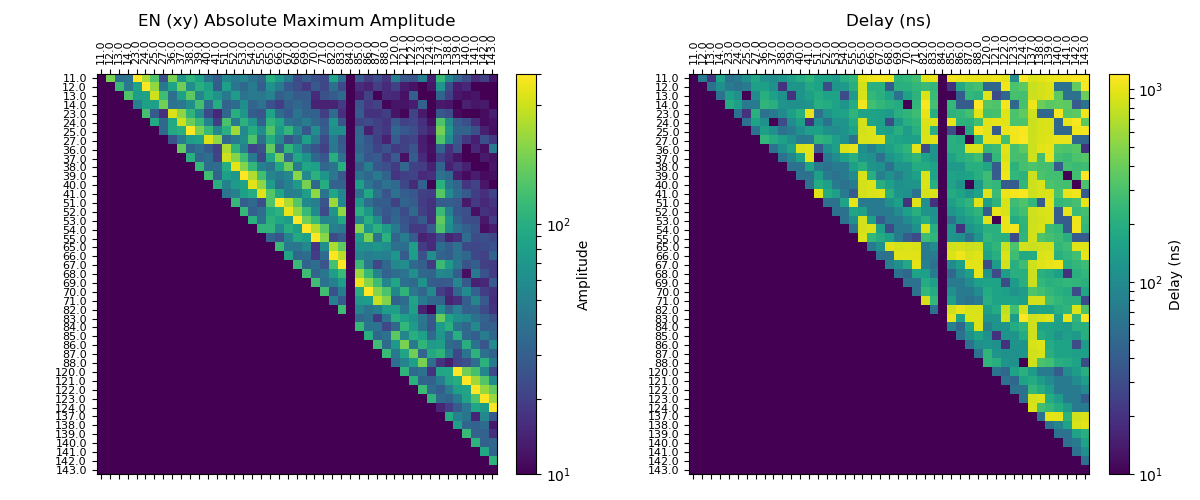

In [6]:
#Call the matrix plotting function

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
adp.plot_matrix_array(amp_array = max_amp_xy, amp_matrix = amp_matrix_xy, delay_matrix = delay_matrix_xy,
                      vmin1 = 10, vmax1 = 400,
                      vmin2 = 10, vmax2 = 1200,
                      title='EN (xy) Absolute Maximum Amplitude')

Now we do the same thing for the yx or NE polarized data

In [7]:
#Initialize the arrays for the amplitudes of the yx data and the corresponding delay
#The only parameter passed is the uv object
max_amp_yx, delay_yx = adp.make_max_arrays(uv = uvyx)

#Print the shape of the arrays to verify that the function worked properly
print delay_yx.shape
print max_amp_yx.shape

#Initialize the matrix arrays of the yx data
#The arrays created above are passed into the function 
amp_matrix_yx, delay_matrix_yx = adp.make_matrix_array(amp_array = max_amp_yx, delay_array = delay_yx)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_yx.shape
print delay_matrix_yx.shape

(1035, 3)
(1035, 3)
(45, 45)
(45, 45)


Now we can plot the matrices. 

<IPython.core.display.Javascript object>


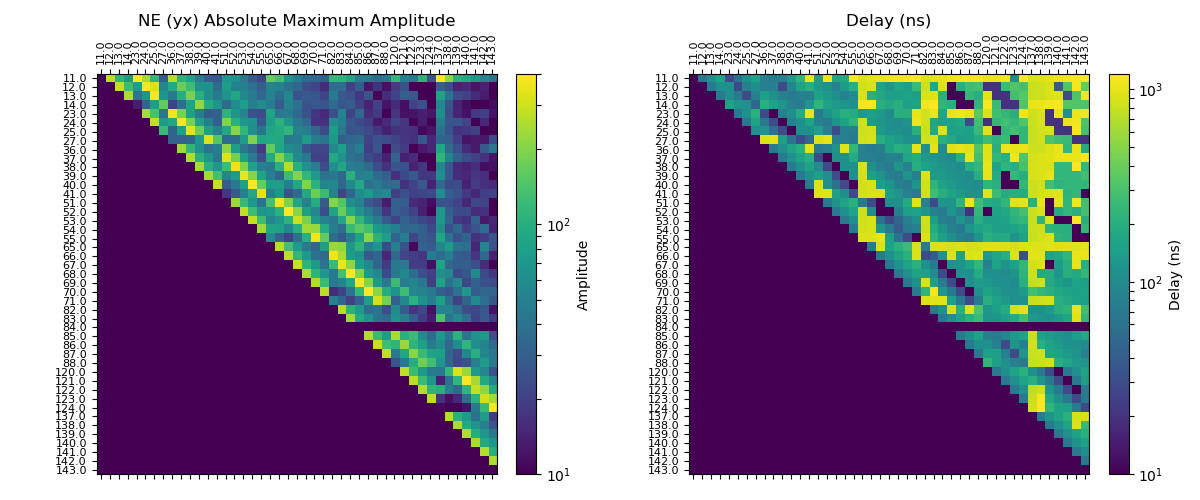

In [8]:
#Call the matrix plotting function

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
adp.plot_matrix_array(amp_array = max_amp_yx, amp_matrix = amp_matrix_yx, delay_matrix = delay_matrix_yx,
                      vmin1 = 10, vmax1 = 400,
                      vmin2 = 10, vmax2 = 1200,
                      title = 'NE (yx) Absolute Maximum Amplitude')

#### Step 3:
To double check that the matrix plots above are making sense, let's take a look at the delay transform for a given set of antennas directly. 

In [10]:
#Get the data for a given set of antennas
vis = uvxy.get_data(11, 65)
#print vis
print vis.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay = np.fft.fftshift(np.fft.fft(np.mean(vis,axis=0)))
#print vis_avg_delay
print vis_avg_delay.shape

# 2) Find the frequency width of a channel in GHz
freq_width = np.diff(uvxy.freq_array[0,:])[0]
print freq_width

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width))*1e9
#print delays
print delays.shape

print np.max(np.abs(vis_avg_delay))
print delays[np.argmax(np.abs(vis_avg_delay))]

(1, 1024)
(1024,)
97656.25
(1024,)
101.75357
-979.9999999999999


In [11]:
#Get the data for a given antenna pair
vis2 = uvyx.get_data(11, 65)
#print vis2
print vis2.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay2 = np.fft.fftshift(np.fft.fft(np.mean(vis2,axis=0)))
#print vis_avg_delay2
print vis_avg_delay2.shape

# 2) Find the frequency width of a channel in GHz
freq_width2 = np.diff(uvyx.freq_array[0,:])[0]
print freq_width2

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays2 = np.fft.fftshift(np.fft.fftfreq(uvyx.Nfreqs,freq_width2))*1e9
#print delays2
print delays2.shape

print np.max(np.abs(vis_avg_delay2))
print delays2[np.argmax(np.abs(vis_avg_delay2))]

(1, 1024)
(1024,)
97656.25
(1024,)
167.99756
-920.0


<IPython.core.display.Javascript object>


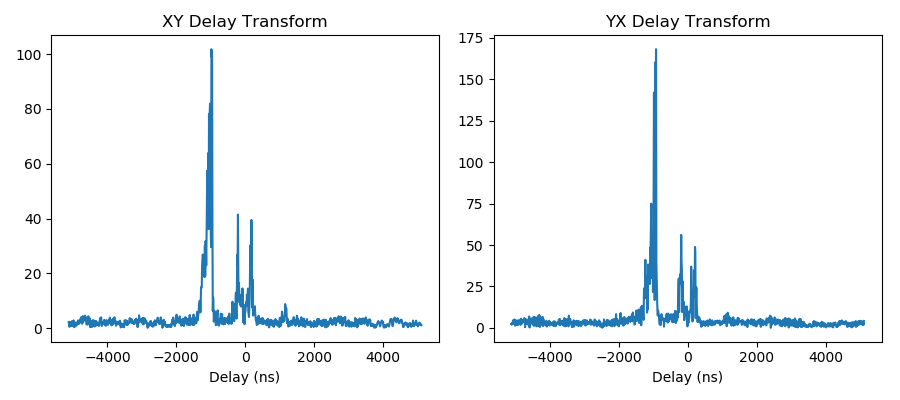

In [12]:
#Plot the two delay transforms

plt.figure(figsize=(9,4))

plt.subplot(121)
plt.plot(delays,np.abs(vis_avg_delay))
plt.xlabel('Delay (ns)')
#plt.xlim(100,200) # zoom-in
#plt.ylim(0,600)
plt.title('XY Delay Transform');

plt.subplot(122)
plt.plot(delays2,np.abs(vis_avg_delay2))
plt.xlabel('Delay (ns)')
#plt.ylim(0,500)
#plt.xlim(-1000,1000) # zoom-in
plt.title('YX Delay Transform');

plt.tight_layout()

Lastly, we plot the two amplitude matrices side by side with the same color scale. This allows us to compare the results and pick out any obvious patterns in the two plots. 

<IPython.core.display.Javascript object>


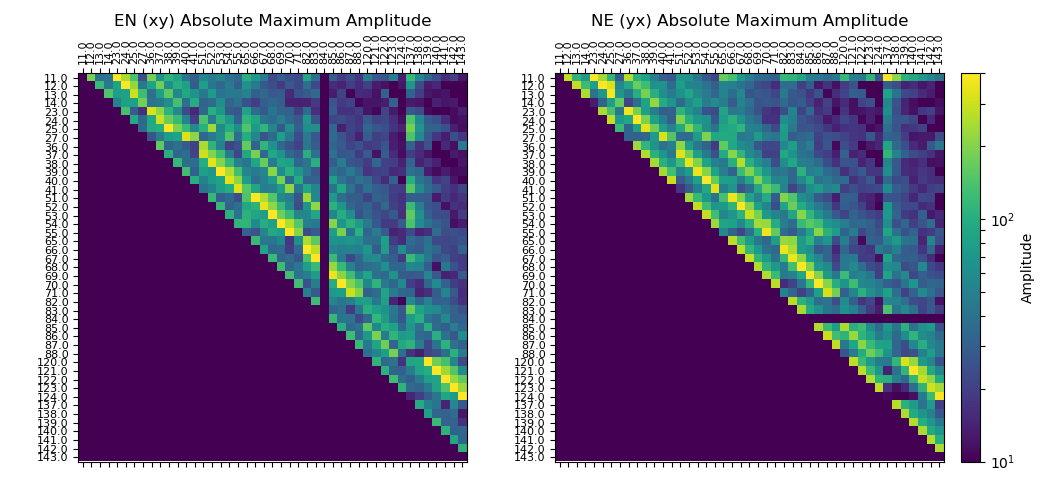

In [13]:
#Plot the amplitudes for both polarizations side by side, with the same color scale
#Make a list of the antennas to use as the tick marks
antennas = list(set(max_amp_xy[:,0]))
antennas.sort()

fig = plt.figure(figsize=(10.5,4.8))

ax_1 = fig.add_subplot(121)
cax_1 = ax_1.matshow(amp_matrix_xy,norm=SymLogNorm(vmin=10,vmax=400,linthresh=.1))
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('EN (xy) Absolute Maximum Amplitude',pad=20)
#plt.grid()

ax_2 = fig.add_subplot(122)
cax_2 = ax_2.matshow(amp_matrix_yx,norm=SymLogNorm(vmin=10,vmax=400,linthresh=.1))
plt.xticks(np.arange(45), antennas, rotation='vertical', fontsize=8)
plt.yticks(np.arange(45), antennas, fontsize=8)
plt.title('NE (yx) Absolute Maximum Amplitude',pad=20)
#plt.grid()

plt.colorbar(cax_2, label='Amplitude',fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Part 2: Antenna position plots

We've been able to plot matrices of the maximum amplitude, but now we want to be able to visualize where the antennas actually are in relation to each other (for instance, could then see that the antennas next to each other are most strongly correlated). 

We will do this by first having the user enter an antenna number. This antenna will be the "focus antenna" which will then be paired with every other antenna to look at the amplitudes and delays, as seen above. Essentially, we will be looking at a single row or column of the matrix plots above. 

#### Step 1: 

First, we find the antenna positions and antenna numbers listed in the data. Then we prompt the user to enter an antenna number. This number is fed into a check function and then the arrays are created.

In [14]:
#Read in the position and antenna numbers for all antennas
antpos, ants = uvxy.get_ENU_antpos()

In [15]:
#Ask the user to input the desired antenna
focus_ant = input("Which antenna would you like to look at? Enter here: ")
#Take the input and represent as an integer
focus_ant = int(focus_ant)
#Run a check that the number is valid
focus_ant = adp.check_antnum(antnum = focus_ant,ants = ants)

Which antenna would you like to look at? Enter here: 65
65


In [16]:
#Call make_array functions for the xy and yx data

#Create the arrays for the max amplitude and corresponding delay for the xy data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_xy, full_ant_delay_xy = adp.make_max_arrays(uv = uvxy, keep_flags = True)

#Create the matrix arrays for the xy data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_xy, all_ants_delay_xy, index, dindex = adp.make_matrix_array(amp_array = full_ant_amp_xy, 
                                                                      delay_array = full_ant_delay_xy, 
                                                                      antnum = focus_ant, index = True)

#Create the arrays for the max amplitude and corresponding delay for the yx data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_yx, full_ant_delay_yx = adp.make_max_arrays(uv = uvyx, keep_flags = True)

#Create the matrix arrays for the yx data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#indexy = index number for the amplitude array
#dindexy = index number for the delay array
all_ants_amp_yx, all_ants_delay_yx, indexy, dindexy = adp.make_matrix_array(amp_array = full_ant_amp_yx, 
                                                                        delay_array = full_ant_delay_yx, 
                                                                        antnum = focus_ant, index = True)

Now we can actually plot the antennas with both amplitude and delay fuctioning as the color scale

<IPython.core.display.Javascript object>


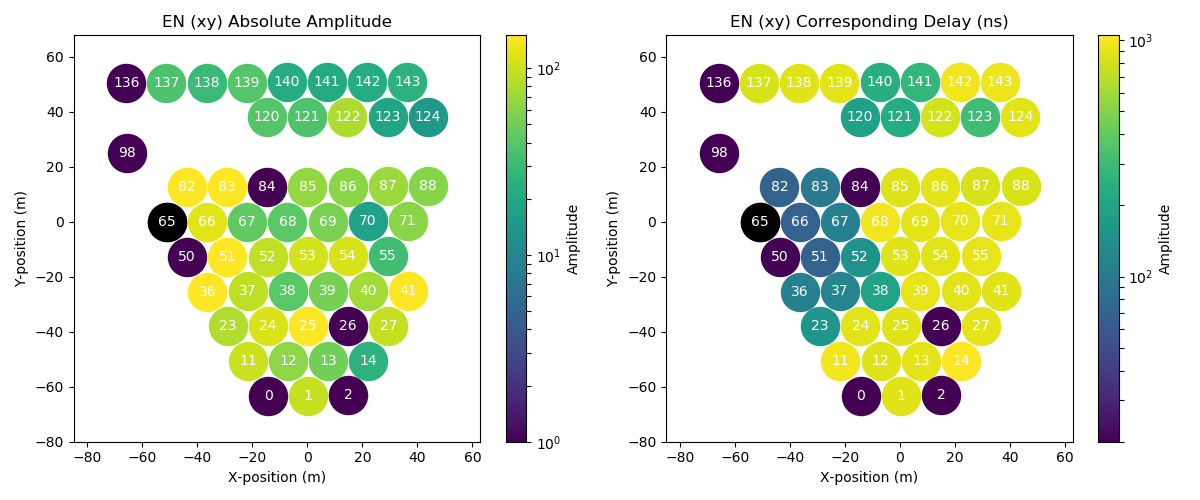

In [20]:
#Call the position plotting function for the xy data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_position_array(amp_array = all_ants_amp_xy, delay_array = all_ants_delay_xy,
                        index = index, dindex = dindex, uv = uvxy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 150,
                        vmin2 = 20, vmax2 = 1050,
                        title1 = 'EN (xy) Absolute Amplitude',
                        title2 = 'EN (xy) Corresponding Delay (ns)')


<IPython.core.display.Javascript object>


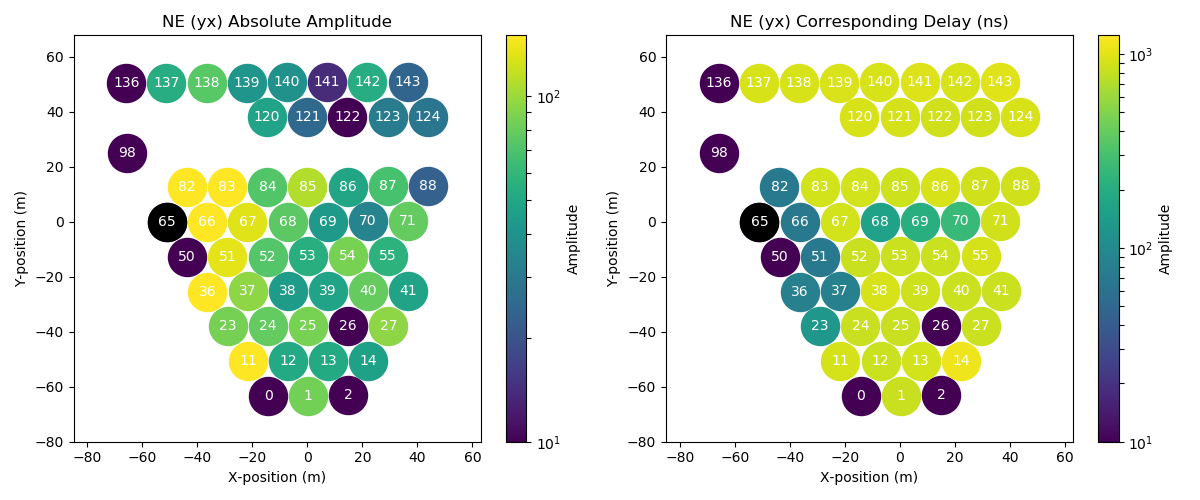

In [25]:
#Call the position plotting function for the yx data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_position_array(amp_array = all_ants_amp_yx, delay_array = all_ants_delay_yx,
                        index = indexy, dindex = dindexy, uv = uvyx, antnum = focus_ant,
                        vmin1 = 10, vmax1 = 150,
                        vmin2 = 10, vmax2 = 1250, 
                        title1 = 'NE (yx) Absolute Amplitude',
                        title2 = 'NE (yx) Corresponding Delay (ns)')

#### Step 2:

Now let's look at how far away the delay times correspond to. This means that instead of plotting the antenna amplitudes at the given antenna location, we need to plot them at the distance given by the delay. 

The delay is given in ns and we need it in m: distance = all_ants_delay[index,aa] $*$ 3e8

OR, taking into account the fact that light moves more slowly in cables:

distance = all_ants_delay[index,aa] $*$ 3e8 $*$ 0.8

We also need to know the physical distance separating the antennas. This is done inside the position plotting functions by calling the find baseline function. 

In [26]:
#Create an array which holds the delay times in meters
delay_distance = all_ants_delay_yx * c
delay_distance_xy = all_ants_delay_xy * c

#Create an array which holds the delay times in meters, with the cable correction factor
dd_cable_yx = all_ants_delay_yx * c * f
dd_cable_xy = all_ants_delay_xy * c * f


<IPython.core.display.Javascript object>


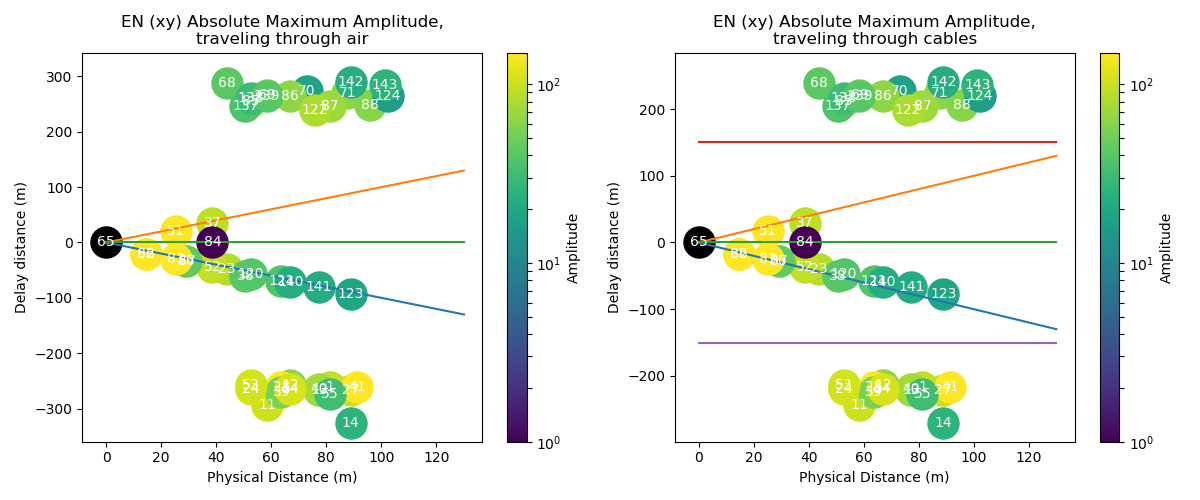

In [27]:
#Call the delay position plotting function for the xy data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_delay_position(amp_1 = all_ants_amp_xy, delay_dis_1 = delay_distance_xy,
                        amp_2 = all_ants_amp_xy, delay_dis_2 = dd_cable_xy,
                        index1 = index, index2 = index, uv = uvxy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 150, vmin2 = 1, vmax2 = 150,
                        title1 = 'EN (xy) Absolute Maximum Amplitude,\ntraveling through air',
                        title2 = 'EN (xy) Absolute Maximum Amplitude,\ntraveling through cables')


<IPython.core.display.Javascript object>


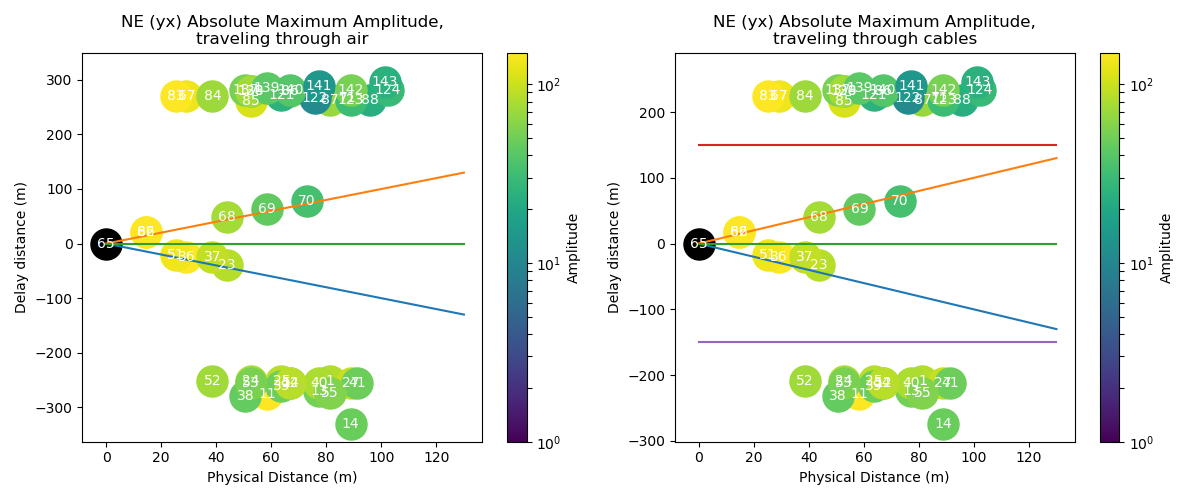

In [28]:
#Call the delay position plotting function for the yx data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified

adp.plot_delay_position(amp_1 = all_ants_amp_yx, delay_dis_1 = delay_distance,
                        amp_2 = all_ants_amp_yx, delay_dis_2 = dd_cable_yx,
                        index1 = indexy, index2 = indexy, uv = uvyx, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 150, vmin2 = 1, vmax2 = 150,
                        title1 = 'NE (yx) Absolute Maximum Amplitude,\ntraveling through air',
                        title2 = 'NE (yx) Absolute Maximum Amplitude,\ntraveling through cables')


### Part 3: Parallel Polarizations

Now we want to take a look at the parallel polarized data and create all the same plots as we have above. 

First we initialize the arrays as above, and then create the plots

In [29]:
# Initialize the array for the amplitudes of the xx and yy data and the corresponding delays

#The only required parameter is the uv object
max_amp_xx, delay_xx = adp.make_max_arrays(uv = uvxx)
max_amp_yy, delay_yy = adp.make_max_arrays(uv = uvyy)

#Print the shape of the arrays to verify that the function worked properly
print delay_xx.shape
print max_amp_xx.shape
print delay_yy.shape
print max_amp_yy.shape

#Initialize the matrix arrays of the xy data
#The arrays created above are passed into the function 
amp_matrix_xx, delay_matrix_xx = adp.make_matrix_array(amp_array = max_amp_xx, delay_array = delay_xx)
amp_matrix_yy, delay_matrix_yy = adp.make_matrix_array(amp_array = max_amp_yy, delay_array = delay_yy)

#Print the shape of the arrays to verify that the function worked properly
print amp_matrix_xx.shape
print delay_matrix_xx.shape
print amp_matrix_yy.shape
print delay_matrix_yy.shape

(1035, 3)
(1035, 3)
(1035, 3)
(1035, 3)
(45, 45)
(45, 45)
(45, 45)
(45, 45)


<IPython.core.display.Javascript object>


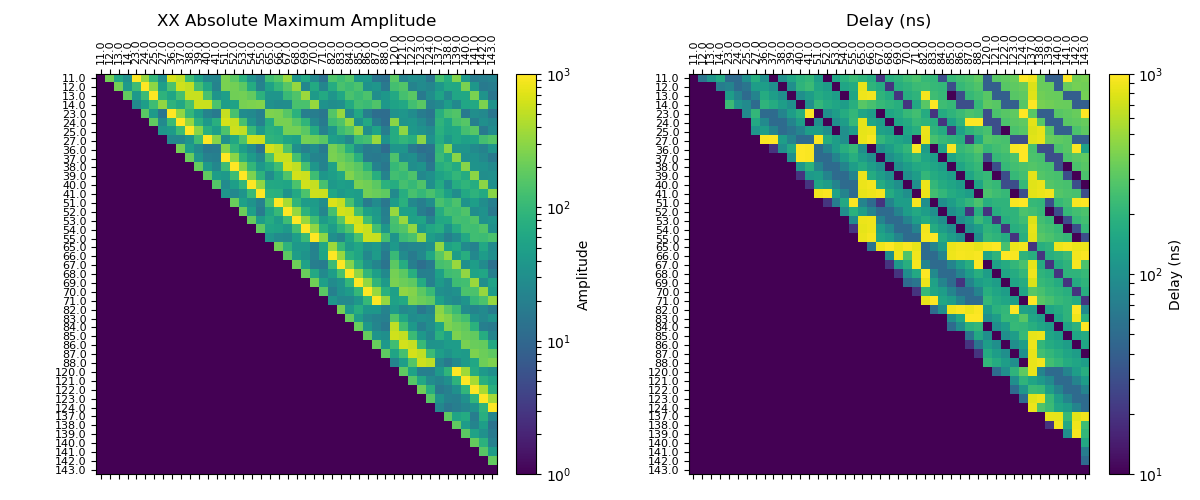

In [31]:
#Call the matrix plotting function for the xx data

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
adp.plot_matrix_array(amp_array = max_amp_xx, amp_matrix = amp_matrix_xx, delay_matrix = delay_matrix_xx,
                      vmin1 = 1, vmax1 = 1000, vmin2 = 10, vmax2 = 1000,
                      title = 'XX Absolute Maximum Amplitude')

<IPython.core.display.Javascript object>


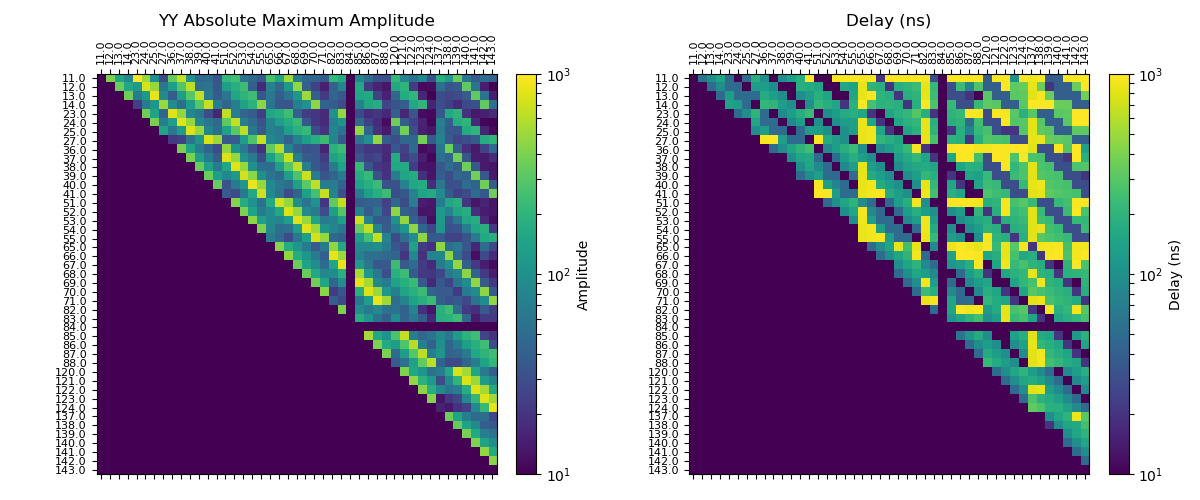

In [33]:
#Call the matrix plotting function for the yy data

#The arrays created above are passed into the function
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The title of the plot is specified
adp.plot_matrix_array(amp_array = max_amp_yy, amp_matrix = amp_matrix_yy, delay_matrix = delay_matrix_yy,
                      vmin1 = 10, vmax1 = 1000, vmin2 = 10, vmax2 = 1000,
                      title = 'YY Absolute Maximum Amplitude')

In [34]:
#Call make_array functions for the xx and yy data

#Create the arrays for the max amplitude and corresponding delay for the xx data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_xx, full_ant_delay_xx = adp.make_max_arrays(uv = uvxx, keep_flags = True)

#Create the matrix arrays for the xx data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_xx, all_ants_delay_xx, indexx, dindexx = adp.make_matrix_array(amp_array = full_ant_amp_xx, 
                                                                      delay_array = full_ant_delay_xx, 
                                                                      antnum = focus_ant, index = True)


#Create the arrays for the max amplitude and corresponding delay for the yy data
#The parameters passed are the uv object and setting keep_flags to True
#By setting keep_flags to True, we keep the flagged antennas listed in the created array,
#which means we are able to plot them in position below
full_ant_amp_yy, full_ant_delay_yy = adp.make_max_arrays(uv = uvyy, keep_flags = True)

#Create the matrix arrays for the yy data
#The two arrays created above are passed into the function
#The antenna entered by the user is passed in
#Index is set to true, which means the array index numbers for the given antenna are returned
#index = index number for the amplitude array
#dindex = index number for the delay array
all_ants_amp_yy, all_ants_delay_yy, indeyy, dindeyy = adp.make_matrix_array(amp_array = full_ant_amp_yy, 
                                                                      delay_array = full_ant_delay_yy, 
                                                                      antnum = focus_ant, index = True)

<IPython.core.display.Javascript object>


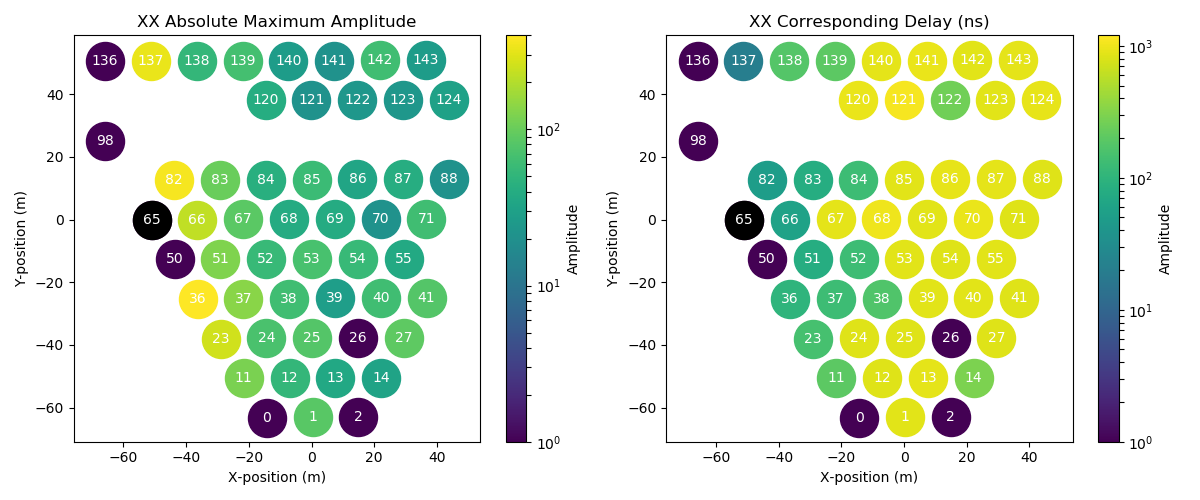

In [35]:
#Call the position plotting function for the xx data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_position_array(amp_array = all_ants_amp_xx, delay_array = all_ants_delay_xx,
                        index = indexx, dindex = dindexx, uv = uvxx, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 400,
                        vmin2 = 1, vmax2 = 1200, 
                        title1 = 'XX Absolute Maximum Amplitude',
                        title2 = 'XX Corresponding Delay (ns)')

<IPython.core.display.Javascript object>


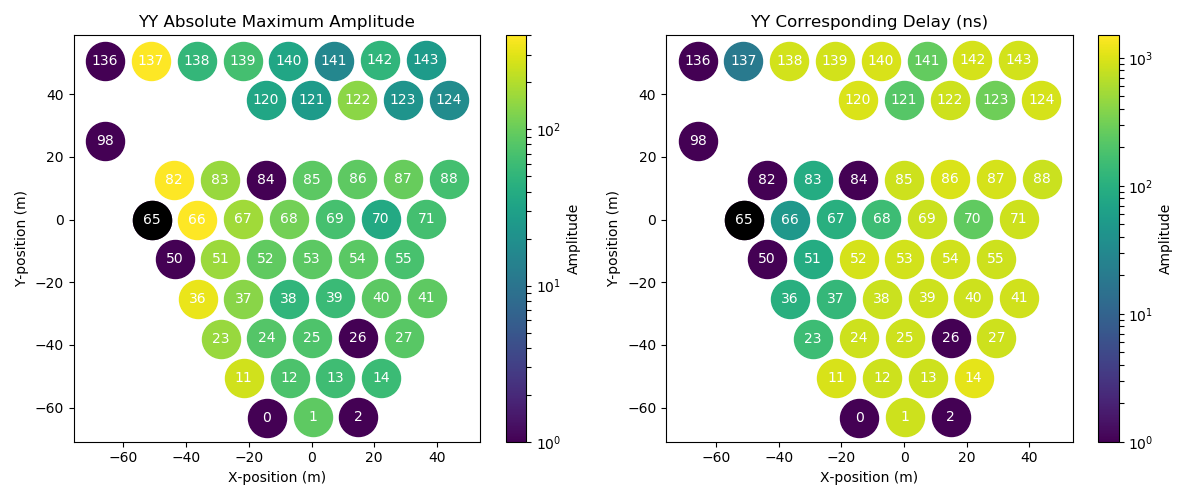

In [36]:
#Call the position plotting function for the yy data

#The arrays created above are passed into the function
#The index and delay index values are passed
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_position_array(amp_array = all_ants_amp_yy, delay_array = all_ants_delay_yy,
                        index = indeyy, dindex = dindeyy, uv = uvyy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 400,
                        vmin2 = 1, vmax2 = 1500, 
                        title1 = 'YY Absolute Maximum Amplitude',
                        title2 = 'YY Corresponding Delay (ns)')

In [37]:
#Create an array which holds the delay times in meters for the xx and yy data
delay_distance_xx = all_ants_delay_xx * c
delay_distance_yy = all_ants_delay_yy * c

#Create an array which holds the delay times in meters, with the cable correction factor
dd_cable_xx = all_ants_delay_xx * c * f
dd_cable_yy = all_ants_delay_yy * c * f


<IPython.core.display.Javascript object>


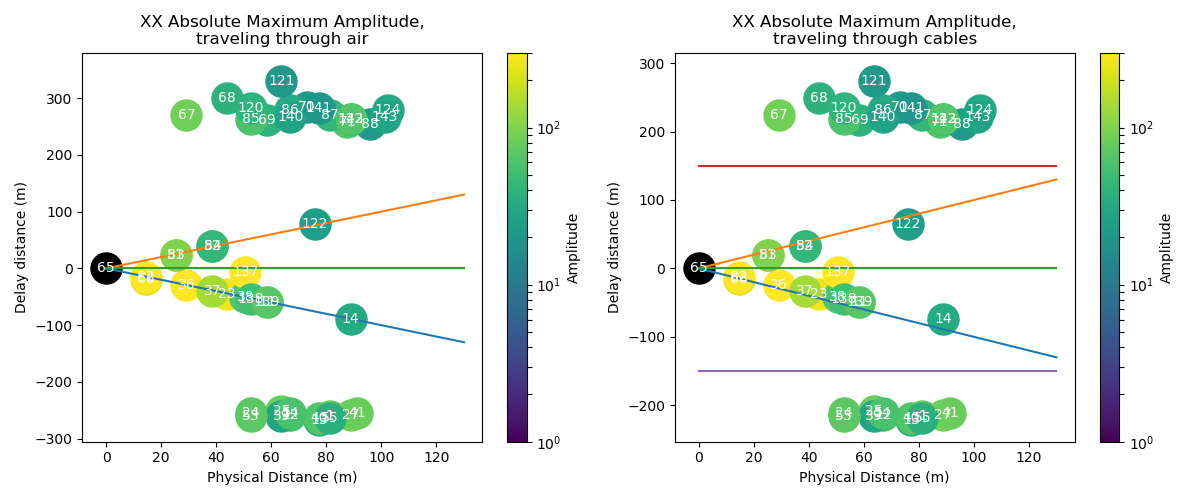

In [38]:
#Call the delay position plotting function for the xx data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_delay_position(amp_1 = all_ants_amp_xx, delay_dis_1 = delay_distance_xx,
                        amp_2 = all_ants_amp_xx, delay_dis_2 = dd_cable_xx,
                        index1 = indexx, index2 = indexx, uv = uvxx, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 300, vmin2 = 1, vmax2 = 300,
                        title1 = 'XX Absolute Maximum Amplitude,\ntraveling through air',
                        title2 = 'XX Absolute Maximum Amplitude,\ntraveling through cables')

<IPython.core.display.Javascript object>


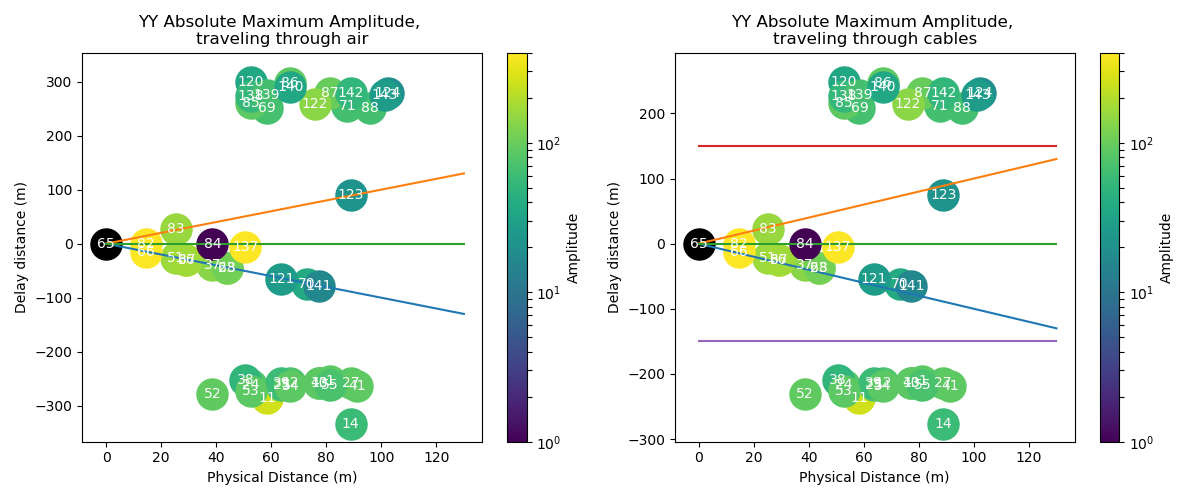

In [39]:
#Call the delay position plotting function for the yy data

#The arrays created above are passed into the function along with the amplitude array
#The index values are passed (they are both index)
#The color scale for the second plot, which corresponds to the delay time, is passed through vmin and vmax
#The titles of the plots are specified
adp.plot_delay_position(amp_1 = all_ants_amp_yy, delay_dis_1 = delay_distance_yy,
                        amp_2 = all_ants_amp_yy, delay_dis_2 = dd_cable_yy,
                        index1 = indeyy, index2 = indeyy, uv = uvyy, antnum = focus_ant,
                        vmin1 = 1, vmax1 = 400, vmin2 = 1, vmax2 = 400,
                        title1 = 'YY Absolute Maximum Amplitude, \ntraveling through air',
                        title2 = 'YY Absolute Maximum Amplitude, \ntraveling through cables')

### Part 4: Making movies

As interesting as all of these plots are, it can be tiring going through and rerunning the code for every antenna you want to take a look at. It would be helpful to be able to make a movie of the plots which cycles through each antenna as the "focus antenna". 

The script below saves out the plots as pngs and can be modified to specify which polarization you would like to run. 

After all of the pngs have been saved, the following command can be entered into the command line to create the movie: 

ffmpeg -framerate 2 -pattern_type glob -i '$*$.png' -c:v libx264 -pix_fmt yuv420p out.mp4

In [ ]:
'''
for focus_ant in ants:
    #Create the arrays for the maximum values and the matrix for yx
    full_ant_amp_yy, full_ant_delay_yy = make_max_arrays(uvpy, keep_flags=True)
    all_ants_amp_yy, all_ants_delay_yy, indeyy, dindeyy = make_matrix_array(full_ant_amp_yy, full_ant_delay_yy, antnum=focus_ant, index=True)

    #Plot the array of antennas with color representing amplitude for xy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',s=3000,color='w')
    for aa in range(52):
        #Get the amplitude value for the current antenna pair
        color = all_ants_amp_yy[indeyy,aa]
        #Convert into integer
        color = int(color)
        #Plot the antennas with the corresponding colors
        xim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=color,norm=SymLogNorm(vmin=10,vmax=5000,linthresh=.1))
    #Print the antetnna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in red
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title('NE antenna correlation')
    plt.axis('equal')
    plt.colorbar(xim)

    #Plot the array of antennas with color representing delay time
    plt.subplot(122)
    plt.scatter(antpos[:,0],antpos[:,1],marker='.',color='w',s=3000)
    for aa in range(52):
        #Get the delay value for the current antenna pair
        dcolor = all_ants_delay_yy[dindeyy,aa]
        #Convert into integer
        dcolor = int(dcolor)
        dcolor = np.abs(dcolor)
        #Plot the antennas with the corresponding colors
        dxim=plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',s=3000,c=dcolor,norm=SymLogNorm(vmin=50,vmax=1500,linthresh=.1))
    #Print the antenna numbers
    for aa,ant in enumerate(ants):
        plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')
        #Print the entered antenna in red
        if ant==focus_ant: plt.scatter(antpos[aa,0],antpos[aa,1],marker='.',color='black',s=3000)
    plt.xlabel('X-position (m)')
    plt.ylabel('Y-position (m)')
    plt.title('YY Delay correlation')
    plt.axis('equal')
    plt.colorbar(dxim)

    plt.tight_layout()

    imname = '0' + str(focus_ant) + '_yy.png'
    plt.savefig('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/ant_array_imgs/yy_imgs/'+imname)
'''